# Load Data

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import gdown

# ID file dari link Google Drive
url = 'https://drive.google.com/uc?export=download&id=1oFDxjDOTohgPzzFxL0-5lddkFMtj47kj'
output = 'dataset_destinasi.zip'  # Nama file lokal untuk menyimpan

# Mengunduh file
gdown.download(url, output, quiet=False)

# Ekstrak file jika perlu
import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("./dataset_destinasi")  # Ekstrak ke folder dataset_destinasi


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1oFDxjDOTohgPzzFxL0-5lddkFMtj47kj
From (redirected): https://drive.google.com/uc?export=download&id=1oFDxjDOTohgPzzFxL0-5lddkFMtj47kj&confirm=t&uuid=785373b8-ca36-4368-b3b5-bfc901ede667
To: /content/dataset_destinasi.zip
100%|██████████| 291M/291M [00:04<00:00, 67.3MB/s]


In [11]:
# Dataset Preparation
DATASET_DIR = "/content/dataset_destinasi/dataset_destinasi"  # Direktori dataset di laptop
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
CLASSES = ["buildings", "forest", "glacier", "mountain", "sea", "street"]


In [12]:
# Transformasi Dataset
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [14]:
# Load Dataset
train_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, 'seg_train'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, 'seg_test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# Number of classes
num_classes = len(train_dataset.classes)
print(num_classes)

6


# Model

## CNN

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

cnn_model = CNN(num_classes=len(CLASSES)).to(device)


## ResNet


In [20]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(CLASSES))
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.4MB/s]


# Latih Model

In [21]:
def train_and_validate(model, optimizer, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss /= len(test_loader)

        # Logging
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


# Evaluasi Model

In [22]:
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=CLASSES))


In [23]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(len(train_acc))
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()


Epoch [1/10], Train Loss: 1.0261, Train Acc: 61.04%, Val Loss: 0.7648, Val Acc: 69.60%
Epoch [2/10], Train Loss: 0.6772, Train Acc: 75.04%, Val Loss: 0.6206, Val Acc: 78.10%
Epoch [3/10], Train Loss: 0.5136, Train Acc: 81.51%, Val Loss: 0.5274, Val Acc: 82.03%
Epoch [4/10], Train Loss: 0.3932, Train Acc: 85.72%, Val Loss: 0.5691, Val Acc: 80.97%
Epoch [5/10], Train Loss: 0.2627, Train Acc: 90.72%, Val Loss: 0.6876, Val Acc: 79.97%
Epoch [6/10], Train Loss: 0.1710, Train Acc: 94.27%, Val Loss: 0.6929, Val Acc: 82.07%
Epoch [7/10], Train Loss: 0.1195, Train Acc: 96.07%, Val Loss: 0.7731, Val Acc: 80.87%
Epoch [8/10], Train Loss: 0.0968, Train Acc: 96.89%, Val Loss: 1.0626, Val Acc: 79.90%
Epoch [9/10], Train Loss: 0.0804, Train Acc: 97.38%, Val Loss: 0.9683, Val Acc: 80.83%
Epoch [10/10], Train Loss: 0.0626, Train Acc: 98.14%, Val Loss: 0.9724, Val Acc: 81.37%
Accuracy: 0.8136666666666666
Classification Report:
               precision    recall  f1-score   support

   buildings       0.

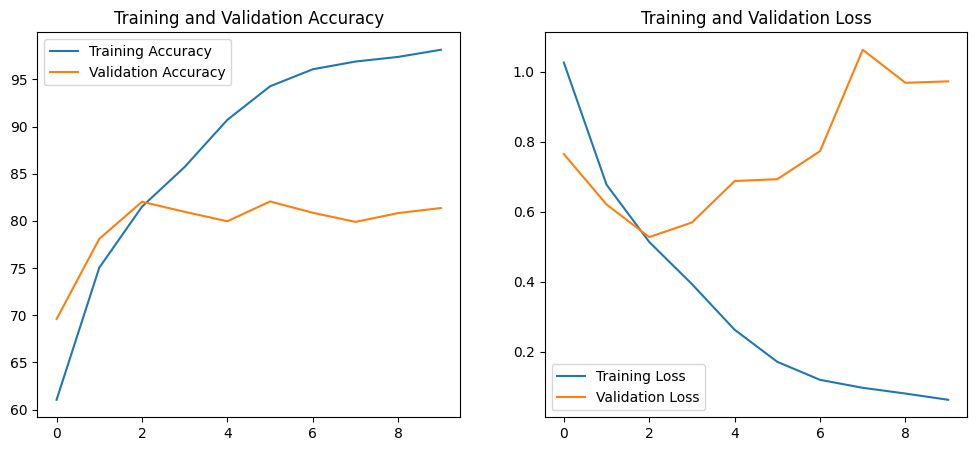

In [24]:
# CNN Model Training
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_and_validate(cnn_model, cnn_optimizer, train_loader, test_loader)

evaluate_model(cnn_model, test_loader)
plot_metrics(cnn_train_acc, cnn_val_acc, cnn_train_loss, cnn_val_loss)
torch.save(cnn_model.state_dict(), "cnn_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Train Loss: 0.4987, Train Acc: 82.94%, Val Loss: 0.4659, Val Acc: 83.67%
Epoch [2/10], Train Loss: 0.3364, Train Acc: 88.31%, Val Loss: 0.3221, Val Acc: 88.07%
Epoch [3/10], Train Loss: 0.3007, Train Acc: 89.67%, Val Loss: 0.3934, Val Acc: 86.27%
Epoch [4/10], Train Loss: 0.2417, Train Acc: 91.46%, Val Loss: 0.3957, Val Acc: 85.83%
Epoch [5/10], Train Loss: 0.2204, Train Acc: 92.40%, Val Loss: 0.3609, Val Acc: 86.93%
Epoch [6/10], Train Loss: 0.1803, Train Acc: 93.73%, Val Loss: 0.3845, Val Acc: 87.47%
Epoch [7/10], Train Loss: 0.1606, Train Acc: 94.47%, Val Loss: 0.4625, Val Acc: 87.27%
Epoch [8/10], Train Loss: 0.1409, Train Acc: 95.09%, Val Loss: 0.5317, Val Acc: 84.73%
Epoch [9/10], Train Loss: 0.1167, Train Acc: 96.06%, Val Loss: 0.4371, Val Acc: 89.07%
Epoch [10/10], Train Loss: 0.0770, Train Acc: 97.40%, Val Loss: 0.4798, Val Acc: 88.40%
Accuracy: 0.884
Classification Report:
               precision    recall  f1-score   support

   buildings       0.93      0.84 

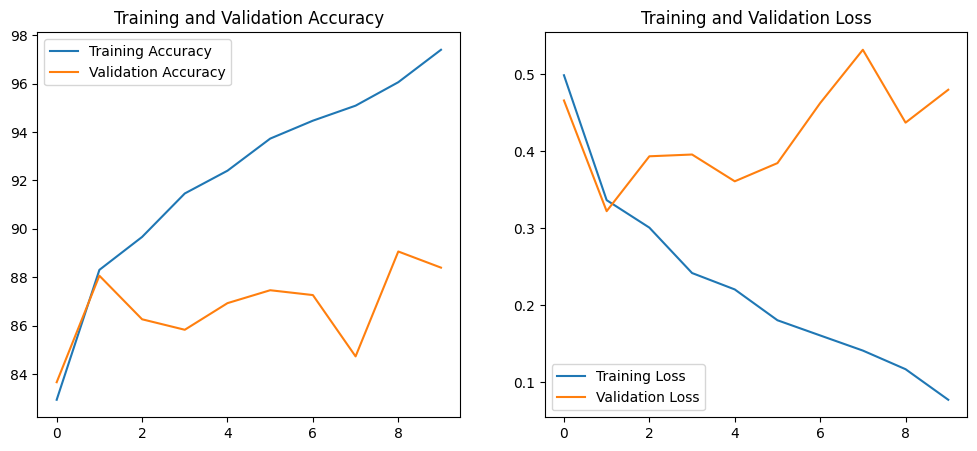

In [25]:
# ResNet Model Training
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc = train_and_validate(resnet_model, resnet_optimizer, train_loader, test_loader)

evaluate_model(resnet_model, test_loader)
plot_metrics(resnet_train_acc, resnet_val_acc, resnet_train_loss, resnet_val_loss)
torch.save(resnet_model.state_dict(), "resnet_model.pth")